# Tutorial 3: An Introduction to Keras
This tutorial covers 
- [What's Keras?](#sec-1)
- [Example: Regression problem](#sec-2)

## What's Keras? <a class="anchor" id="sec-1"></a>
Keras ([https://keras.io](https://keras.io)) is a deep learning API for Python. It is built on top of Tensorflow ([https://www.tensorflow.org/](https://www.tensorflow.org/)), and its primary purpose is to enable fast experimentation by offering simple workflows. Keras is great for learning and will suffice for many applied deep learning projects.

TensorFlow is one of the most popular and powerful deep learning frameworks, but its use is more complicated when compared to Keras. For ADAMS, simplicity rules and matters more than the greater flexibility Tensorflow or other popular frameworks like [PyTorch](https://pytorch.org/), [MXNet](https://mxnet.apache.org/) have to offer. 

Let's start with Keras. To that end, we will first present the anatomy of Neural Networks from Keras's perspective. Then, we will illustrate its use with a regression example and let you get your hands-on with a multiclass classification exercise. 

### Keras's perspective
In Keras, the main class is the `Layer`. A layer is a module that transforms tensors, like LEGO bricks. The type of the layer depends on the tensor format and the type of data. For example, 
- Rank-2 tensor (samples, features) &rarr; dense layer (`Dense`).
- Rank-3 tensor, such as sequence data, (samples, time, features) &rarr; recurrent layer (`LSTM`, `Conv1D`).
- Rank-4 tensor, e.g. images &rarr; 2D convolution layer (`Conv2D`).

`Layers` are assembled into the `Model` class. A deep learning model is not more than a graph of layers. For example, a model can be a stack of layers mapping a single input to a single output. That corresponds to the subclass of `Model` called `Sequential` in Keras. For example,

```python
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) # it does not have activation (linear layer by default)
])
```

However, as long as we dive further in the course, we will find other network topologies, including two-branch networks, residual connections, etc. 

Before training your model, you will need to decide
- which `optimizer` (`RMSprop`, `SGD`, etc.) you to use, 
- which `loss` function is adequate for the problem (`MeanSquaredError`, `CategoricalCrossentropy`, etc.), and 
- what `metrics` you want to monitor (`MAE`, `Accuracy`, etc.). 

All three are specified through the `compile()` method. 

Next, you'll use the `fit()` method to train the model. This method implements the loop itself, and its key arguments are the `data`, the number of `epochs`, and the `batch` size. Here we can also monitor the loss and metrics on the `validation` data.

Finally, when the model is trained, we want to use it in new data. To this end, we use the method `predict()` to generate predictions on new data.

## Example: Regression problem <a class="anchor" id="sec-2"></a>
Let's learn how to use Keras with an example. The idea is to predict the median value of owner-occupied homes (in thousands of dollars) in a Boston suburb, given features such as crime rate, the average number of rooms, and so forth. We structure the task in 5 steps:
1. Get the dataset.
2. Prepare the data for the training. Here we transform the data to be suitable for a neural network.
3. Build the model. We create the layers (`Dense` layer), graph (`Sequential` model) and compile the model (`compile()`).
4. Validate the approach. We commonly use training and validation sets to tune our model (`fit()`). Then, retrain the model with the fine-tuned parameters and evaluate the model in the test set.
5. Make predictions on a new dataset. Commonly on the test set (`predict()`).

### 1. Get the dataset
Let's load the data

In [29]:
from tensorflow.keras.datasets import boston_housing
import numpy as np
# this will split the data 80-20% by default
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
# if you want to try out different options, do the following
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

In [30]:
# Let's take a look at the shape of the data
print('Shape of train data:',x_train.shape,
'\nShape of test data:', x_test.shape)

Shape of train data: (404, 13) 
Shape of test data: (102, 13)


In [31]:
# Let's take a look at the features
import pandas as pd
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


The descriptions of the features are the following (more details about this dataset can be found in [http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston))
| # | Variable | Description |
|---|---|---|
| 1 | CRIM | per capita crime rate by town |
| 2 | ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| 3 | INDUS | proportion of non-retail business acres per town |
| 4 | CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 5 | NOX | nitric oxides concentration (parts per 10 million) |
| 6 | RM | average number of rooms per dwelling |
| 7 | AGE | proportion of owner-occupied units built prior to 1940 |
| 8 | DIS | weighted distances to five Boston employment centres |
| 9 | RAD | index of accessibility to radial highways |
| 10 | TAX | full-value property-tax rate per $10,000 |
| 11 | PTRATIO | pupil-teacher ratio by town |
| 12 | B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| 13 | LSTAT | % lower status of the population |

So, we have 404 samples to train and 102 to test, each with 13 numerical features. The target is the median values of homes. Let's have a quick look at them

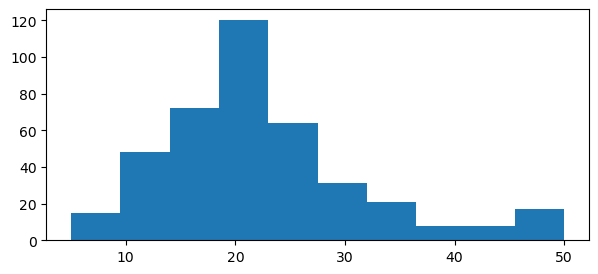

In [4]:
#Plot the values of the target variable: 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=7,3
plt.hist(y_train)
plt.show()

### 2. Data preparation
We saw that `x_train` takes different ranges. This is problematic for neural networks, so a common practice is to standardize each feature.

In [5]:
#Feature rescaling:
#Get the mean and the standard deviation of each feature on your train dataset:
num_val_samples = int(len(x_train)*0.25)

x_tr=x_train[:-num_val_samples]
y_tr=y_train[:-num_val_samples]

x_val = x_train[-num_val_samples:]
y_val = y_train[-num_val_samples:]



mean_train = x_tr.mean(axis=0) # axis 0, along the rows or column-wise operation
std_train = x_tr.std(axis=0)

#Rescale train dataset by subtracting the mean (so that each feature has a mean of 0 after that)
#and by dividing by the standard deviation (so that each feature has a standard deviation of 1.0 after that)
x_tr_rescaled =(x_tr- mean_train)/std_train
# apply this very same transformation to the validation set and the test set (never compute means and stds on validation and test set!)
x_val_rescaled=(x_val- mean_train)/std_train
x_test_rescaled=(x_test-mean_train)/std_train

In [6]:
print('Shape train data: ',x_tr_rescaled.shape)
print('Shape validation data: ',x_val_rescaled.shape)
print('Shape test data: ',x_test.shape)

Shape train data:  (303, 13)
Shape validation data:  (101, 13)
Shape test data:  (102, 13)


In [7]:
print('Means of train features: ',np.around(x_tr_rescaled.mean(axis=0),3))
print('Standard deviation of train features: ',np.around(x_tr_rescaled.std(axis=0),3))

Means of train features:  [-0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.]
Standard deviation of train features:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
print('Means of validation features: ',np.around(x_val_rescaled.mean(axis=0),3))
print('Standard deviation of validation features: ',np.around(x_val_rescaled.std(axis=0),3))

Means of validation features:  [-0.153 -0.014 -0.123  0.162 -0.158  0.126 -0.244  0.082 -0.063 -0.032
 -0.105  0.152 -0.196]
Standard deviation of validation features:  [0.614 1.028 0.964 1.274 0.908 1.113 1.033 0.934 0.976 0.94  0.991 0.748
 0.974]


In [9]:
print('Means of test features: ',np.around(x_test_rescaled.mean(axis=0),3))
print('Standard deviation of test features: ',np.around(x_test_rescaled.std(axis=0),3))

Means of test features:  [-0.103 -0.028 -0.007  0.202 -0.15   0.158 -0.14   0.152  0.046  0.061
 -0.072  0.132 -0.109]
Standard deviation of test features:  [0.534 0.911 1.028 1.33  0.916 0.973 1.05  1.15  0.999 1.047 0.917 0.792
 0.917]


Due to slightly different distribution of the fatures in the validation and the test dataset, when we rescale it using the means and the standard deviations computed on the train set, we get rescaled validation and test features, the mean and standard deviation of which is not exactly 0.0 and 1.0, respectively. **Is this a problem?**


**Should we also rescale the target variable?**

In [10]:
#mean_train_target=y_train.mean()
#std_train_target=y_train.std()

#y_train_rescaled=(y_train-mean_train_target)/std_train_target
#y_test_rescaled=(y_test-mean_train_target)/std_train_target

### 3. Building the model
We are ready to build our model. Since the sample size is small, two layers with 64 units will be enough to avoid overfitting. We use ReLU as the non-linearity. 

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
#Build the model:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu",kernel_initializer='he_normal'))
model.add(layers.Dense(64, activation="relu",kernel_initializer='he_normal'))
model.add(layers.Dense(1))#without specifying the activation function we implictly choose linear

We compile our model using `Adam` as the optimization algorithm. Of course, there are many other alternatives for the `optimizer`, such as `SGD`, `Adagrad`, `Adadelta`, etc. (see [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/)).

We use the Mean Square Error as the loss (`mse`) (see [https://keras.io/api/losses/](https://keras.io/api/losses/) for other alternatives). We also track the Mean Absolute Error (`mae`) defined in `metrics`. 

In [12]:
#compile the model:
model.compile(optimizer='Adam', 
    loss='mse', # mean squared error, widely used for regression problems
    metrics=['mae']) # we are also monitoring the mean absolute error 

### 4. Validate the approach
In this step, we fit the model and we use the train set and the validation set we created earlier.

In [13]:
# Fit the model:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode='min',min_delta=0.5)

history = model.fit(x_tr_rescaled,
                    y_tr,
                    epochs = 100,
                    batch_size = 16,
                    validation_data= (x_val_rescaled, y_val),
                    callbacks=[early_stopping],
                    verbose = 1)

Epoch 1/100
19/19 [==============================] - 1s 9ms/step - loss: 418.4333 - mae: 18.3859 - val_loss: 436.1189 - val_mae: 18.6535
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 271.1007 - mae: 14.2470 - val_loss: 259.9025 - val_mae: 13.9379
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 144.1244 - mae: 9.8744 - val_loss: 114.0145 - val_mae: 8.3146
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 67.3649 - mae: 6.3213 - val_loss: 63.7813 - val_mae: 6.2869
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 45.6028 - mae: 5.0146 - val_loss: 53.7720 - val_mae: 5.6695
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 36.7319 - mae: 4.3953 - val_loss: 43.7507 - val_mae: 4.9749
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 30.9437 - mae: 4.0120 - val_loss: 36.3929 - val_mae: 4.4776
Epoch 8/100
19/19 [==============================] - 0s 3ms

Let's plot the training and validation loss

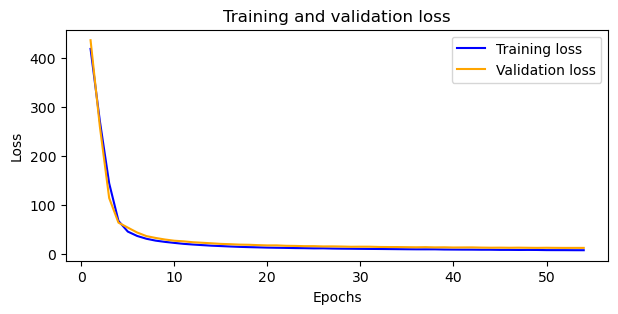

In [14]:
#Plot the training and the validation loss using the training history from the fitted model:
loss = history.history["loss"] # retrieve the loss in the training set
val_loss = history.history["val_loss"] # retrieve the loss in the validation set
epochs = range(1, len(loss)+1)
plt.rcParams['figure.figsize']=7,3
plt.plot(epochs, loss, color='blue', label = "Training loss")#"bo",
plt.plot(epochs, val_loss, color='orange', label = "Validation loss")#"b",
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
results_train = model.evaluate(x_tr_rescaled, y_tr,verbose=0)
results_val = model.evaluate(x_val_rescaled, y_val,verbose=0)

print('MSE train set: ',results_train[0])
print('MSE val set:',results_val[0],'\n')

print('MAE train set: ',results_train[1])
print('MAE val set: ',results_val[1])

MSE train set:  7.236645698547363
MSE val set: 12.29987621307373 

MAE train set:  1.9238202571868896
MAE val set:  2.5579428672790527


There is a (small) gap in the performance of the model on the train and the validation set in terms of MSE and MAE. When we retrain it on the entire train and validation subset, and test is on the unseen test set, most probably the gap will become bigger!

In [16]:
#Save pre-trained weights and use them as the starting point:
trained_weights=model.get_weights()

In [17]:
#Take a look at a subset of your pre-trained weights:
print('Subset of already trained weights: ')
trained_weights[0][0][:10]

Subset of already trained weights: 


array([ 0.5433012 , -0.57008773, -0.2908468 , -0.01152988, -0.02605528,
       -0.06716207, -0.36779675, -0.24171981,  0.0244044 , -0.25519913],
      dtype=float32)

In [19]:
#Build the model again:
#compile it, train it with train and validation set, and test it:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1))

model.compile(optimizer='Adam', 
    loss='mse', 
    metrics=['mae'])

model.build(input_shape=[None,x_tr_rescaled.shape[1]])

In [20]:
print('Subset of newly initialized weights: ')
model.get_weights()[0][0][:10]

Subset of newly initialized weights: 


array([ 0.26568797,  0.05504641, -0.14378114, -0.05642046, -0.07807741,
        0.19555724,  0.00653622,  0.07902321, -0.10416283, -0.02700892],
      dtype=float32)

In [21]:
model.set_weights(trained_weights)

In [22]:
print('After setting previous weights: ')
model.get_weights()[0][0][:10]

After setting previous weights: 


array([ 0.5433012 , -0.57008773, -0.2908468 , -0.01152988, -0.02605528,
       -0.06716207, -0.36779675, -0.24171981,  0.0244044 , -0.25519913],
      dtype=float32)

In [23]:
x_train_rescaled=(x_train-x_train.mean(axis=0))/x_train.std(axis=0)
x_test_rescaled=(x_test-x_train.mean(axis=0))/x_train.std(axis=0)

model.fit(x_train_rescaled,
                    y_train,
                    epochs = 100,
                    batch_size = 16,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss',
                                                             patience=10,
                                                             mode='min',
                                                             min_delta=0.5)],
                    verbose = 0)

results_train = model.evaluate(x_train_rescaled, y_train,verbose=0)
results_test = model.evaluate(x_test_rescaled, y_test,verbose=0)

print('MSE train set: ',results_train[0])
print('MSE test set:',results_test[0],'\n')

print('MAE train set: ',results_train[1])
print('MAE test set: ',results_test[1])




MSE train set:  3.2636451721191406
MSE test set: 13.811532974243164 

MAE train set:  1.2979215383529663
MAE test set:  2.4187893867492676


Based on the results we would need to perform some hyperparameter tuning/check the performance of other model configurations on the validation set to reduce the gap in the performance of the model (Section 6).

### 5. Generate predictions on new data
The function `predict()` returns the predicted median price of the houses (in $1,000).

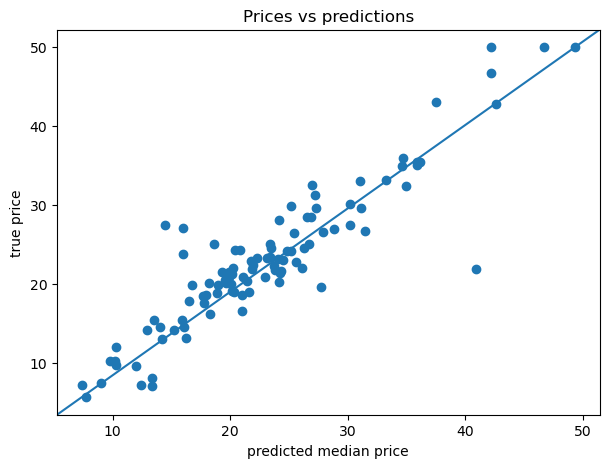

In [24]:
#Generate predictions and plot them:
predictions = model.predict(x_test_rescaled,verbose=0)

# Let's plot the true prices versus the predictions
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(predictions, y_test)
ax.plot([0, 1], [0, 1], transform=ax.transAxes) # add diagonal as a reference
plt.title("Prices vs predictions")
plt.xlabel("predicted median price")
plt.ylabel("true price")
plt.show()
plt.close()

The predictions of the model are however correlated with the true values of the target variable. But there is stil potential to improve the model.

### 6. Tuning the model

We will tune the following hyperparameters of the model:
- reduce the capcity of the model
- add regularization penalty to the loss function
- increase the learning rate

In [28]:
model = keras.Sequential([layers.Dense(10, activation="relu",kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.L1(l1=0.1)),
                          layers.Dense(1)])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.2),#previously we did not specify the lr,we took the standrad lr=0.001
              loss='mse', metrics=['mae'])
model.fit(x_tr_rescaled,y_tr,
         epochs = 100,batch_size = 16,
         validation_data= (x_val_rescaled, y_val),
         callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode='min',min_delta=0.05)],
          verbose = 0)

results_train = model.evaluate(x_tr_rescaled, y_tr,verbose=0)
results_val = model.evaluate(x_val_rescaled, y_val,verbose=0)

print('MSE train set: ',results_train[0])
print('MSE val set:',results_val[0],'\n')

print('MAE train set: ',results_train[1])
print('MAE val set: ',results_val[1])

MSE train set:  16.22934913635254
MSE val set: 17.401315689086914 

MAE train set:  2.540011405944824
MAE val set:  2.601144552230835


Once we are done with the hyperparameter tuning, we will again retrain on the entire train and validation set with the best model configuration found during the tuning, and check the performance on the test set.